# Day 20

https://adventofcode.com/2020/day/20

In [523]:
import numpy as np

def getTiles(filename):
    with open(filename) as f:
        #blocks = [ b.split(":\n") for b in f.read().split("\n\n") ] # there's final \n to be removed from last tile
        blocks = [ b.split(":\n") if b[-1]!="\n" else b[0:-1].split(":\n") for b in f.read().split("\n\n") ]
    tiles_string = []
    for b in blocks:
        tn = int(b[0].replace("Tile ",""))
        tile = b[1].split("\n")
        tiles_string.append((tn,tile))
    tilesdic = {}
    tiles = []
    for (n,t) in tiles_string:
        tile = np.array( [[1 if c=="#" else 0 for c in r ] for r in t], ndmin=2) 
        tiles.append((n,tile))
        tilesdic[n] = tile
    return tiles, tilesdic

In [524]:
#tiles = getTiles("data/day20test0.txt")
tiles, tilesdic = getTiles("data/input20.txt") # remove last newline from input

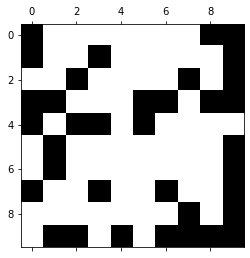

In [525]:
import matplotlib
import matplotlib.pyplot as plt

n,t = tiles[0]
plt.matshow(t,cmap="binary")
plt.show()

## Part 1

> To check that you've assembled the image correctly, multiply the IDs of the four corner tiles together.

In order to do this I don't really need to solve the puzzle (yet!), just to find the 4 corners. Corners will only have 2 borders in common with other 2 pieces.

**Careful!** Since the pieces can be rotated, I should not only check for direct correpondence, but also flipping one side!

In [526]:
def getAdiacentSimple(tiles):

    tborders = []
    for n,t in tiles:
        tborders.append((n,[t[0],t[:,9],t[9],t[:,0]]))
    sameb = {}

    for n0,tb0 in tborders:
        sameb[n0] = []
        for b0 in tb0:
            for n,tb in tborders:
                if n==n0: # same piece, skip
                    continue
                for b in tb:
                    if (b==b0).all() or (b==b0[::-1]).all(): # check both orientations!
                        sameb[n0].append(n)
                        #print(n0,b0,n,b)
    return sameb, tborders

sameb, tborders = getAdiacentSimple(tiles)

sol1 = 1
for n in sameb.keys():
    #print(n,len(sameb[n]))
    if len(sameb[n])==2:
        sol1 *= n
print("Solution Part 1 =", sol1)

Solution Part 1 = 29125888761511


## Part 2

> Assemble the tiles into an image. 

So ultimately we should indeed solve the puzzle before proceeding to solve the second part. And of course:

> each image tile has been rotated and flipped to a random orientation.

I could start from the `sameb` dictionary to solve the piece relative placement ignoring orientation (up to a flip on the puzzle diagonal), and I could maybe solve the orientation a second step, but after several attempt I cannot write I decent alogorithm to do it, so I'll probably write something more complex including border matching and rotation, so I can proceed by placing one piece after the other following the rows. I can probably still use the `sameb` dictionary to reduce the number of pieces to try at each step, but I'm sure it's worth the effort

In [527]:
from copy import deepcopy

class Tile():
    """Puzzle tile"""

    def __init__(self, n, tile, debug=False):
        self.n = n
        self.tile = deepcopy(tile)
        self.recolorBorders()
        self.pos = (-1,-1)
        self.matched = False
        
    def getBorders(self):
        '''Returns list of borders (order: top, right, bottom, left) '''
        return [self.tile[0],   # TOP
                self.tile[:,9], # RIGHT
                self.tile[9],   # BOTTOM
                self.tile[:,0]  # LEFT
               ]

    def recolorBorders(self):
        for c in range(10):
            for r in range(10):
                if r==0 or r==9 or c==0 or c==9:
                    if self.tile[c][r]==1: 
                        self.tile[c][r]=2
    
    def rotate(self,s=1):
        '''Rotate tile CCW'''
        self.tile = np.rot90(self.tile,s)

    def flipLR(self):
        '''Flip tile Left-Right'''
        self.tile = np.fliplr(self.tile)
        
    def flipUD(self):
        '''Flip tile Up-Down'''
        self.flipud()
    
    def flip(self):
        '''Flip tile'''
        self.flip()

In [543]:
from copy import deepcopy

def solvePuzzle(tiles):

    # Compute puzzle size (number of tiles per size), prepare grid to save piece numbers and pieces when solving
    side = int(len(tiles)**0.5)
    puzzle = np.zeros((side,side),dtype=int)
    puzzleall = np.zeros((side*10,side*10),dtype=int)

    # Fill dictionary of Tile() objects
    piece = {}
    for n,t in tiles:
        piece[n] = Tile(n,t)

    # Separate pieces in Angles, Borders and Centers
    sameb, tborders = getAdiacentSimple(tiles)
    tiles_family = [[],[],[]] # angles, borders, centers

    for p in sameb.keys():
        b = len(sameb[p])
        if b==2:
            tiles_family[0].append(p)
        elif b==3:
            tiles_family[1].append(p)
        elif b==4:
            tiles_family[2].append(p)

    # Begin with one angle tile, find what are the common borders with its neighbouring tiles, 
    # orient it such that it is on the top left corner, with the common borders facing RIGHT and DOWN

    bnames = ["TOP","RIGHT", "BOTTOM", "LEFT"]

    p0 = tiles_family[0][0]
    print("Starting angle",p0,"neighbouring with tiles",sameb[p0])

    b0 = piece[p0].getBorders()

    order = []
    for p in sameb[p0]:
        for b in piece[p].getBorders():
            for i in range(4):
                if (b0[i]==b).all() or (b0[i]==b[::-1]).all(): # check both orientations!
                    print("Tile",p,"neighbourd with",bnames[i],"border of angle tile",p0)
                    order.append(i)
                
    if (order==[0,1]): 
        print("Initial angle should be rotated 90 deg CW i.e. 270 deg CCW...",end=" ")
        piece[p0].rotate(3)
        print("done.")
    elif (order==[1,2]):
        print("No need to rotate initial angle!")

    puzzle[0][0] = p0
    piece[p0].pos = (0,0)
    piece[p0].match = True

    print("Solving puzzle...")

    # Solve first line matching right-left borders from top left angle

    current = p0 # top left angle

    for c in range(1,side): 
        pos = (0,c)
        bordertomatch = piece[current].getBorders()[1] # right border
        skipnext = False

        for t in sameb[current]:
            for b in piece[t].getBorders():
                if (bordertomatch==b).all() or (bordertomatch==b[::-1]).all():
                    #print("Found matching piece, now orienting it...", end=" ")
                    tile = deepcopy(piece[t].tile) # make a copy of the tile for further flipping
                    oriented = False
                
                    for _ in range(4):
                        if (bordertomatch==piece[t].getBorders()[3]).all():
                            oriented = True
                            break
                        piece[t].rotate()
                
                    if not oriented:
                        piece[t].tile = tile
                        piece[t].flipLR()
                        for _ in range(4):
                            if (bordertomatch==piece[t].getBorders()[3]).all():
                                oriented = True
                                break
                            piece[t].rotate()
                
                    if not oriented:
                        piece[t].tile = tile
                        piece[t].flipUD()
                        for _ in range(4):
                            if (bordertomatch==piece[t].getBorders()[3]).all():
                                oriented = True
                                break
                            piece[t].rotate()        

                    if not oriented:
                        piece[t].tile = tile
                        piece[t].flip()
                        for _ in range(4):
                            if (bordertomatch==piece[t].getBorders()[3]).all():
                                oriented = True
                                break
                            piece[t].rotate() 

                    if oriented:
                        #print("done.")
                        current = t
                        piece[t].matched = True
                        piece[t].pos = pos
                        puzzle[0][c] = t
                        skipnext = True
                        break

            if skipnext:
                break

    print("First line done!")

    # Solve rest of the puzzle by matching bottom-top borders for all other cells

    for r in range(1,side): 
        for c in range(side):
            pos = (r,c)
            current = puzzle[r-1,c] # tile above
            bordertomatch = piece[current].getBorders()[2] # bottom border 
            skipnext = False
            for t in sameb[current]:
                for b in piece[t].getBorders():
                    if (bordertomatch==b).all() or (bordertomatch==b[::-1]).all():
                        #print("Found matching piece, now orienting it...", end=" ")

                        tile = deepcopy(piece[t].tile) # make a copy of the tile for further flipping
                        oriented = False

                        for _ in range(4):
                            if (bordertomatch==piece[t].getBorders()[0]).all(): # top border!
                                oriented = True
                                break
                            piece[t].rotate()

                        if not oriented:
                            piece[t].tile = tile
                            piece[t].flipLR()
                            for _ in range(4):
                                if (bordertomatch==piece[t].getBorders()[0]).all():
                                    oriented = True
                                    break
                                piece[t].rotate()

                        if not oriented:
                            piece[t].tile = tile
                            piece[t].flipUD()
                            for _ in range(4):
                                if (bordertomatch==piece[t].getBorders()[0]).all():
                                    oriented = True
                                    break
                                piece[t].rotate()

                        if not oriented:
                            piece[t].tile = tile
                            piece[t].flip()
                            for _ in range(4):
                                if (bordertomatch==piece[t].getBorders()[0]).all():
                                    oriented = True
                                    break
                                piece[t].rotate()

                        if oriented:
                            #print("done.")
                            current = t
                            piece[t].matched = True
                            piece[t].pos = pos
                            puzzle[r][c] = t
                            skipnext = True
                            break
                if skipnext:
                    break

    print("Puzzle solved!")
    
    return side, puzzle, puzzleall, piece

Starting angle 2833 neighbouring with tiles [1907, 3761]
Tile 1907 neighbourd with RIGHT border of angle tile 2833
Tile 3761 neighbourd with BOTTOM border of angle tile 2833
No need to rotate initial angle!
Solving puzzle...
First line done!
Puzzle solved!


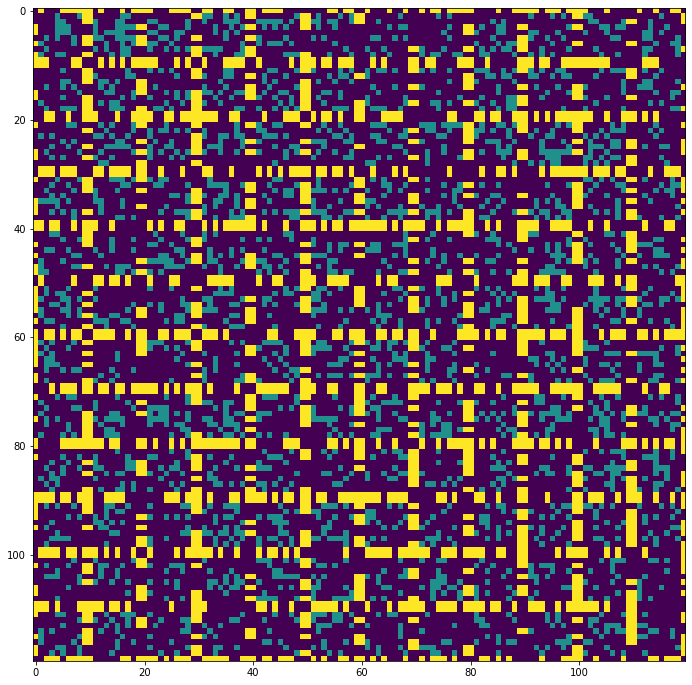

In [578]:
# Get puzzle input using function from Part 1

#tiles, _ = getTiles("data/day20test0.txt")
tiles, _ = getTiles("data/input20.txt")

# Solve puzzle

side, puzzle, puzzleall, piece = solvePuzzle(tiles)

# Draw puzzle to check solution

for i in range(side):
    for j in range(side):
        puzzleall[ 10*j:10*(j+1), 10*i:10*(i+1)] = piece[puzzle[j][i]].tile

plt.figure(figsize=(12,12))
plt.imshow(puzzleall)
plt.show()

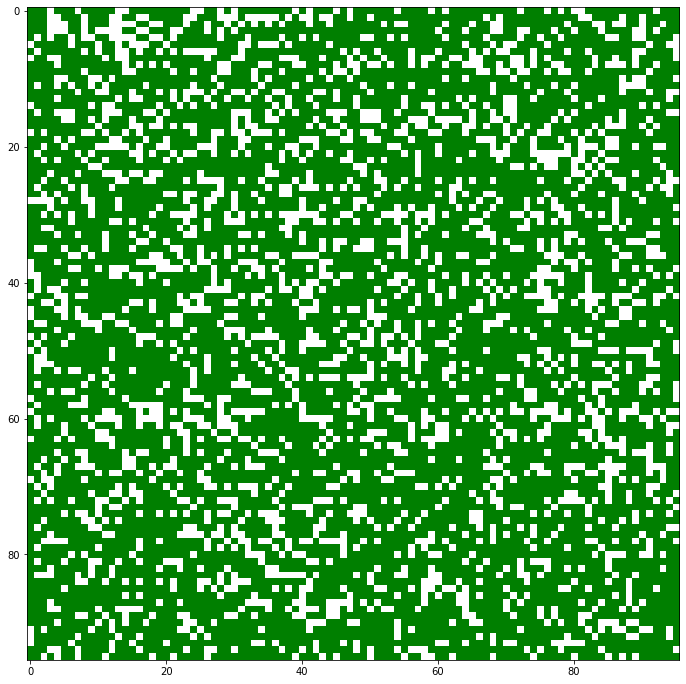

In [579]:
# Now removing borders and filling the "sea"

sea = np.zeros((side*8,side*8),dtype=int)

for p in piece.keys():
    r,c = piece[p].pos
    sea[8*r:8*(r+1),8*c:8*(c+1)] = piece[p].tile[1:9,1:9]

plt.figure(figsize=(12,12))
plt.imshow(sea,cmap=plt.cm.ocean)
plt.show()

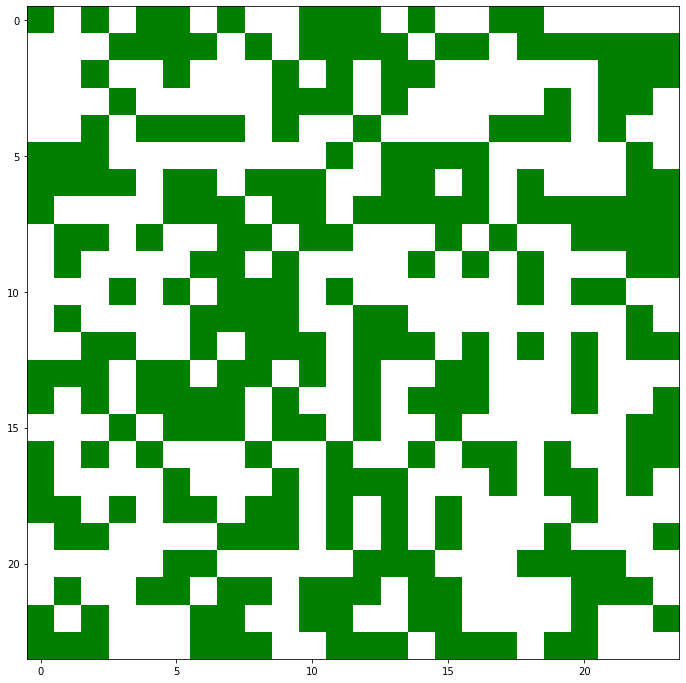

In [580]:
# Plot example sea to check image reconstitution solution by eye :-)

with open("data/day20test1.txt") as f:
    lines =  [l.strip("\n") for l in f.readlines()]
seaexample = []
for l in lines:
    r = []
    for c in l:
        if c=="#":
            r.append(1)
        else:
            r.append(0)
    seaexample.append(r)

plt.figure(figsize=(12,12))
plt.imshow(seaexample,cmap=plt.cm.ocean)
plt.show()

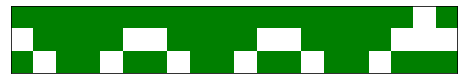

(3, 20)
15


In [587]:
seamonster_lines = [
    "                  # ",
    "#    ##    ##    ###",
    " #  #  #  #  #  #   "
]

seamonster = []
for l in seamonster_lines:
    seamonster.append([ 0 if p==" " else 1 for p in l])

seamonster = np.array(seamonster)

plt.figure(figsize=(8,8))
f = plt.imshow(seamonster,cmap=plt.cm.ocean)
f.axes.get_xaxis().set_visible(False)
f.axes.get_yaxis().set_visible(False)
plt.show()

print(np.shape(seamonster))
print(sum(sum(seamonster)))

In [582]:
h,l = np.shape(seamonster)

def isSeaMonster(searegion,seamonster):
    _sum = 0
    for rr,mm in zip(searegion,seamonster):
        for r,m in zip(rr,mm):
            _sum += r and m
    if _sum == sum(sum(seamonster)):
        return True
    else:
        return False

def addMonster(sea,rr,cc,seamonster):
    rm = 0
    for r in range(rr,rr+h):
        cm = 0
        for c in range(cc,cc+l):
            sea[r][c] += seamonster[rm][cm]
            cm += 1
        rm +=1

sea_w_monsters = deepcopy(sea)

_sea = deepcopy(sea)

monstercount = 0

for _ in range(4):
    for r in range(0,len(sea[0])-h+1):
        for c in range(0,len(sea)-l+1):
            searegion = sea[r:r+h,c:c+l]
            if isSeaMonster(searegion,seamonster):
                monstercount+=1
                addMonster(sea_w_monsters,r,c,seamonster)
    sea = np.rot90(sea)
    sea_w_monsters = np.rot90(sea_w_monsters)

sea = deepcopy(_sea)
sea = np.fliplr(sea)

sea_w_monsters = np.fliplr(sea_w_monsters)

for _ in range(4):
    for r in range(0,len(sea[0])-h+1):
        for c in range(0,len(sea)-l+1):
            searegion = sea[r:r+h,c:c+l]
            if isSeaMonster(searegion,seamonster):
                monstercount+=1
                addMonster(sea_w_monsters,r,c,seamonster)
    sea = np.rot90(sea)
    sea_w_monsters = np.rot90(sea_w_monsters)

# The lines below testing more flipping configurations are redundant, if used I get 2x monsters

#sea = deepcopy(_sea)
#sea = np.flipud(sea)
#for _ in range(4):
#    for r in range(0,len(sea[0])-h+1):
#        for c in range(0,len(sea)-l+1):
#            searegion = sea[r:r+h,c:c+l]
#            if isSeaMonster(searegion,seamonster):
#                monstercount+=1
#    sea = np.rot90(sea)

#sea = deepcopy(_sea)
#sea = np.flip(sea)

#for _ in range(4):
#    for r in range(0,len(sea[0])-h+1):
#        for c in range(0,len(sea)-l+1):
#            searegion = sea[r:r+h,c:c+l]
#            if isSeaMonster(searegion,seamonster):
#                monstercount+=1
#    sea = np.rot90(sea)
    
#        plt.figure(figsize=(8,8))
#        plt.imshow(searegion,cmap=plt.cm.ocean)
#        plt.show()

print("Sea contains",monstercount,"monsters")
print("The habitat's water roughness is",sum(sum(sea))-monstercount*sum(sum(seamonster)))

Sea contains 15 monsters
The habitat's water roughness is 2219


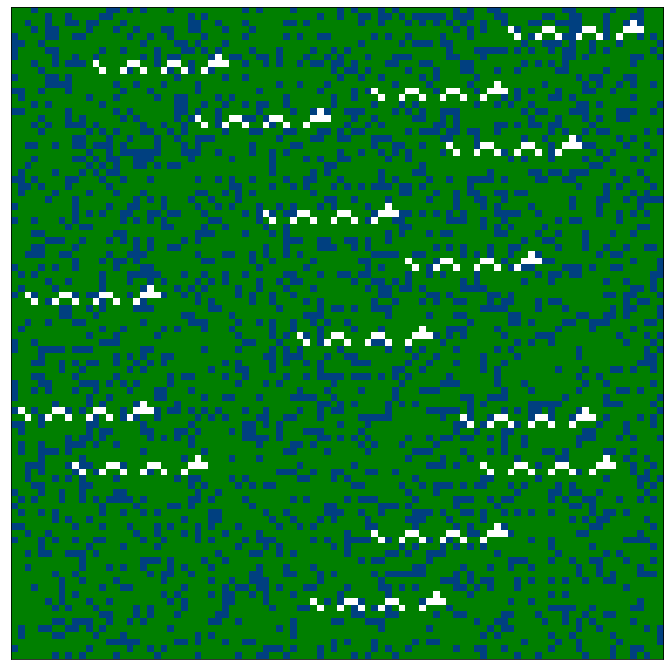

In [586]:
plt.figure(figsize=(12,12))
f = plt.imshow(sea_w_monsters,cmap=plt.cm.ocean)
f.axes.get_xaxis().set_visible(False)
f.axes.get_yaxis().set_visible(False)
plt.show()